## Book to create Visualizations to compare Leagues and Former Teams/Leagues 

In [1]:
# Depencies

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np




########### Connect to the SQLite database
# #### 2022 SEASON DATA
db_path = '../../TEMP/2022_Game_Stats_Cleaned_Backup.db'  # Most recent YTD Stats for 2022
# roster_path = '../../data/rosters/2022_master_roster.csv'
# # #################################################################


# #### 2023 (YTD) SEASON DATA ######
# db_path = '../../data/Game_Stats_Cleaned.db'  # Most recent YTD Stats for 2023
# roster_path = '../../data/rosters/2023_master_roster.csv'
# #################################################################

# Connect to the database - Load Roster As dataframe
conn = sqlite3.connect(db_path)
# master_roster_df = pd.read_csv(roster_path)

## DEFINE master_roster_df HERE
master_roster_df = pd.read_sql_query("SELECT * FROM master_roster", conn)

# ################## TEMP FIX TO CORRECT BAD COLUMN HEADERS IN THE player_stats_df 
# ############ 'Pt.' should be 'Pts' and '+/-' should be 'plus_minus'
# #################################
# player_stats_df = pd.read_sql_query("SELECT * FROM player_stats", conn)
# player_stats_df.rename(columns={'Pt.':'Pts'}, inplace=True)
# player_stats_df.rename(columns={'+/-':'plus_minus'}, inplace=True)
# #################################

# # Send the dataframe back to the database
# player_stats_df.to_sql('player_stats', conn, if_exists='replace', index=False)

# # Do the same for player_stats_ytd
# player_stats_ytd_df = pd.read_sql_query("SELECT * FROM player_stats_ytd", conn)
# player_stats_ytd_df.rename(columns={'Pt.':'Pts'}, inplace=True)
# player_stats_ytd_df.rename(columns={'+/-':'plus_minus'}, inplace=True)
# player_stats_ytd_df.to_sql('player_stats_ytd', conn, if_exists='replace', index=False)



### Check the health of the data with a quick summary

In [2]:

### Any tables Missing Game_ID Column - the roster and summary tables should not have one
def find_missing_game_id_tables(db_path):
    conn = sqlite3.connect(db_path)
    table_query = "SELECT name FROM sqlite_master WHERE type='table';"
    table_names = [table[0] for table in conn.execute(table_query).fetchall()]
    
    missing_game_id_tables = []
    for table_name in table_names:
        columns_query = f"PRAGMA table_info({table_name});"
        columns = [column[1] for column in conn.execute(columns_query).fetchall()]
        if 'Game_ID' not in columns:
            missing_game_id_tables.append(table_name)
            
    return missing_game_id_tables

# Usage

print(find_missing_game_id_tables(db_path))


['master_roster_2022', 'player_stats_ytd', 'master_roster']


In [3]:
# Code to summarize the database and CSV contents for the user to run

def summarize_data(db_path, csv_path):
    # Database connection
    conn = sqlite3.connect(db_path)
    
    # Get table names
    table_query = "SELECT name FROM sqlite_master WHERE type='table';"
    table_names = [table[0] for table in conn.execute(table_query).fetchall()]
    
    # Summary dictionary to hold various metrics
    summary = {}
    
    # Count total number of games in database
    game_query = "SELECT COUNT(DISTINCT Game_ID) FROM game_details;"
    total_games = conn.execute(game_query).fetchone()[0]
    summary["Total Games in DB"] = total_games

    # Count missing tables for each game
    missing_tables = {}
    for game_id in conn.execute("SELECT DISTINCT Game_ID FROM game_details").fetchall():
        game_id = game_id[0]
        missing_tables[game_id] = []
        for table in table_names:
            count_query = f"SELECT COUNT(*) FROM {table} WHERE Game_ID = ?;"
            count = conn.execute(count_query, (game_id,)).fetchone()[0]
            if count == 0:
                missing_tables[game_id].append(table)
    
    # Most missed tables
    all_missing_tables = [table for sublist in missing_tables.values() for table in sublist]
    most_missed_table = pd.Series(all_missing_tables).value_counts().idxmax()
    
    summary["Games Missing Tables"] = len([k for k, v in missing_tables.items() if v])
    summary["Most Missed Table"] = most_missed_table
    
    # Count total number of unique players and teams in the master_roster table and CSV
    player_query = "SELECT COUNT(DISTINCT Name) FROM master_roster_2023;"
    team_query = "SELECT COUNT(DISTINCT School) FROM master_roster_2023;"
    
    total_db_players = conn.execute(player_query).fetchone()[0]
    total_db_teams = conn.execute(team_query).fetchone()[0]
    
    # Count from CSV
    csv_data = pd.read_csv(csv_path)
    total_csv_players = csv_data['Name'].nunique()
    total_csv_teams = csv_data['School'].nunique()
    
    summary["Total Players in DB"] = total_db_players
    summary["Total Teams in DB"] = total_db_teams
    summary["Total Players in CSV"] = total_csv_players
    summary["Total Teams in CSV"] = total_csv_teams
    
    return summary

# Show the code block to the user so they can run it on their machine
summarize_data_code_block = '''
import sqlite3
import pandas as pd

def summarize_data(db_path, csv_path):
    # Database connection
    conn = sqlite3.connect(db_path)
    
    # Get table names
    table_query = "SELECT name FROM sqlite_master WHERE type='table';"
    table_names = [table[0] for table in conn.execute(table_query).fetchall()]
    
    # Summary dictionary to hold various metrics
    summary = {}
    
    # Count total number of games in database
    game_query = "SELECT COUNT(DISTINCT Game_ID) FROM game_details;"
    total_games = conn.execute(game_query).fetchone()[0]
    summary["Total Games in DB"] = total_games

    # Count missing tables for each game
    missing_tables = {}
    for game_id in conn.execute("SELECT DISTINCT Game_ID FROM game_details").fetchall():
        game_id = game_id[0]
        missing_tables[game_id] = []
        for table in table_names:
            count_query = f"SELECT COUNT(*) FROM {table} WHERE Game_ID = ?;"
            count = conn.execute(count_query, (game_id,)).fetchone()[0]
            if count == 0:
                missing_tables[game_id].append(table)
    
    # Most missed tables
    all_missing_tables = [table for sublist in missing_tables.values() for table in sublist]
    most_missed_table = pd.Series(all_missing_tables).value_counts().idxmax()
    
    summary["Games Missing Tables"] = len([k for k, v in missing_tables.items() if v])
    summary["Most Missed Table"] = most_missed_table
    
    # Count total number of unique players and teams in the master_roster table and CSV
    player_query = "SELECT COUNT(DISTINCT Name) FROM master_roster_2023;"
    team_query = "SELECT COUNT(DISTINCT School) FROM master_roster_2023;"
    
    total_db_players = conn.execute(player_query).fetchone()[0]
    total_db_teams = conn.execute(team_query).fetchone()[0]
    
    # Count from CSV
    csv_data = pd.read_csv(csv_path)
    total_csv_players = csv_data['Name'].nunique()
    total_csv_teams = csv_data['School'].nunique()
    
    summary["Total Players in DB"] = total_db_players
    summary["Total Teams in DB"] = total_db_teams
    summary["Total Players in CSV"] = total_csv_players
    summary["Total Teams in CSV"] = total_csv_teams
    
    return summary

# Usage
db_path = 'path/to/Game_Stats_Cleaned.db'
csv_path = 'path/to/2023_master_roster.csv'
print(summarize_data(db_path, csv_path))
'''

summarize_data_code_block


'\nimport sqlite3\nimport pandas as pd\n\ndef summarize_data(db_path, csv_path):\n    # Database connection\n    conn = sqlite3.connect(db_path)\n    \n    # Get table names\n    table_query = "SELECT name FROM sqlite_master WHERE type=\'table\';"\n    table_names = [table[0] for table in conn.execute(table_query).fetchall()]\n    \n    # Summary dictionary to hold various metrics\n    summary = {}\n    \n    # Count total number of games in database\n    game_query = "SELECT COUNT(DISTINCT Game_ID) FROM game_details;"\n    total_games = conn.execute(game_query).fetchone()[0]\n    summary["Total Games in DB"] = total_games\n\n    # Count missing tables for each game\n    missing_tables = {}\n    for game_id in conn.execute("SELECT DISTINCT Game_ID FROM game_details").fetchall():\n        game_id = game_id[0]\n        missing_tables[game_id] = []\n        for table in table_names:\n            count_query = f"SELECT COUNT(*) FROM {table} WHERE Game_ID = ?;"\n            count = conn.exe

### Group by League of Previous league

Attempting to answer the question. Where Do Goals Come From?

Creates catagories to clean up the data from the column

In [4]:
def group_leagues(league):
    if pd.isna(league):
        return 'Blank / Unknown'
    elif league in ['USHL', 'NAHL', 'BCHL', 'AJHL']:
        return league  # Major leagues can have their own category
    elif league in ['SWE', 'FIN', 'Europe', 'Oberliga', 'Finland', 'Sweden']:
        return 'Europe'
    elif league in ['NCHC', 'CCHA', 'HEA', 'ECAC', 'B10', 'Big10', 'Big Ten', 'AHA', 'WCHA',
                    'DI Independent', 'D-I Independent', 'D1 Independent', 'NCAA D3', 'NCAA DIII',
                    'Atlantic Hockey', 'ACHA', 'USports']:
        return 'College Transfers'
    elif league in ['USPHL', 'USPHL NCDC', 'NCDC']:
        return 'USPHL'
    elif league == 'NTDP':
        return 'US NTDP'
    else:
        return 'Others'

# Then, apply this function to create a new column for grouped leagues.
master_roster_df['Grouped_League'] = master_roster_df['League'].apply(group_leagues)

# Add the master roster to the database
master_roster_df.to_sql('master_roster', conn, if_exists='replace', index=False)


1748

In [5]:
### HOW MANY UNIQUE FEEDER LEAGUES ARE IN THE MASTER ROSTER

# Get the unique feeder leagues

# Open roster as dataframe
# master_roster_df = pd.read_csv(roster_path)

# Get the unique League names
unique_leagues = master_roster_df['League'].unique()
print(f"There are {len(unique_leagues)} unique feeder leagues in the master roster table.")

# Value counts of each league
master_roster_df['Grouped_League'].value_counts()

# Print the unique leagues
# print(unique_leagues)


There are 57 unique feeder leagues in the master roster table.


Grouped_League
USHL                 491
College Transfers    394
NAHL                 266
BCHL                 226
Others               133
AJHL                  91
Blank / Unknown       58
USPHL                 40
US NTDP               38
Europe                11
Name: count, dtype: int64

In [6]:
# Print tables in the database
# conn = sqlite3.connect(db_path)
table_query = "SELECT name FROM sqlite_master WHERE type='table';"
table_names = [table[0] for table in conn.execute(table_query).fetchall()]
print(table_names)

['scoring_summary', 'penalty_summary', 'goalie_stats', 'line_chart', 'linescore', 'advanced_metrics_team1', 'advanced_metrics_team2', 'player_stats', 'master_roster_2022', 'game_details', 'player_stats_ytd', 'advanced_metrics_combined', 'master_roster']


## Simple barchart of TOTAL GOALS by Former League

In [7]:
### print column names of player_stats_ytd table
player_stats_df = pd.read_sql_query("SELECT * FROM player_stats_ytd", conn)
print(player_stats_df.columns)

Index(['Clean_Player', 'Team', 'G', 'A', 'Pts', 'plus_minus', 'Sh', 'PIM',
       'Games_Played'],
      dtype='object')


C:\Users\Justin\AppData\Local\Temp\ipykernel_15412\2010832097.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Grouped_League', y='Total_Goals', data=grouped_league_stats_df,
C:\Users\Justin\AppData\Local\Temp\ipykernel_15412\2010832097.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Grouped_League', y='Total_Goals', data=grouped_league_stats_df,


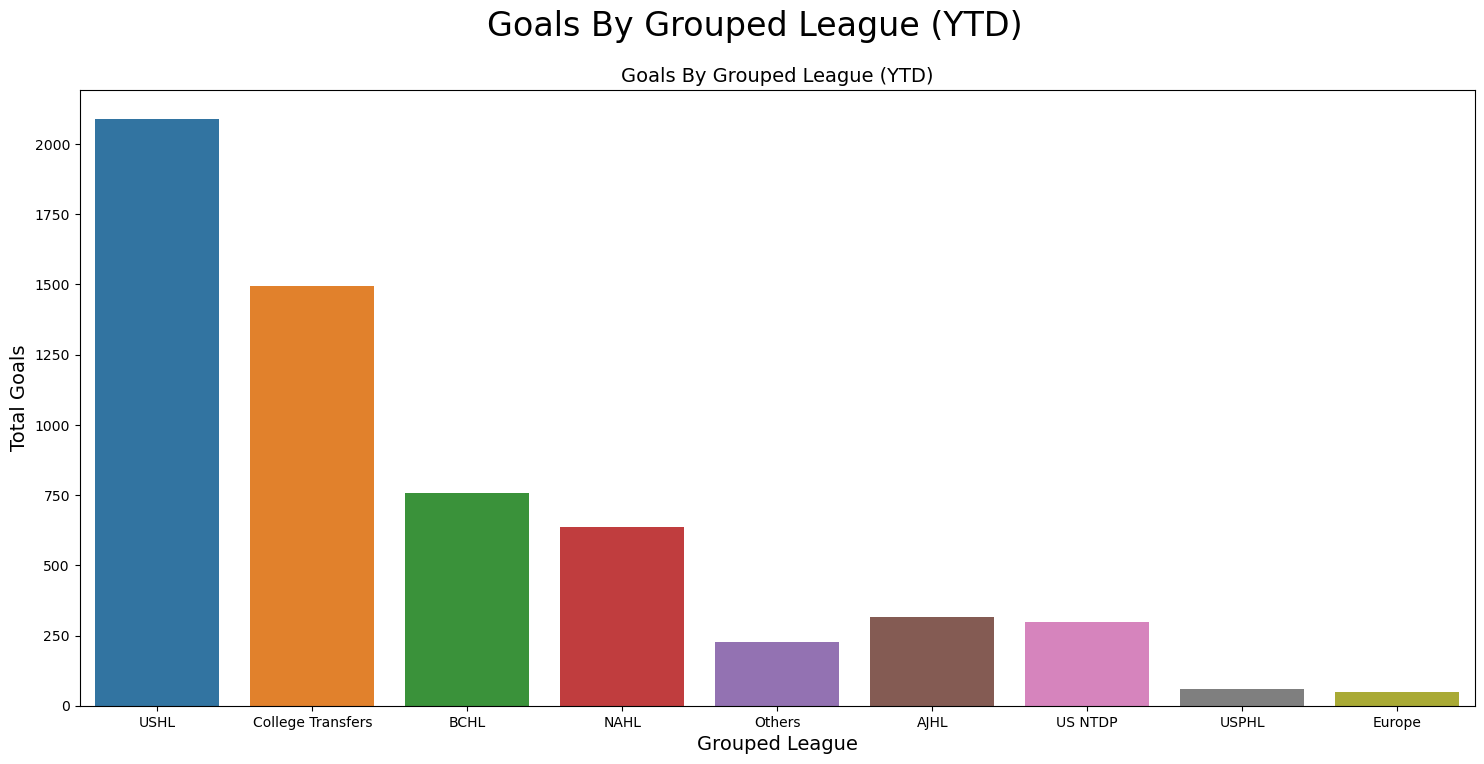

In [8]:
# SQL query to group player stats by the grouped league categories
grouped_league_stats_query_final_ytd = """
SELECT
    CASE
        WHEN mr.League IN ('NCHC', 'CCHA', 'HEA', 'ECAC', 'B10', 'Big10', 'Big Ten', 'AHA', 'WCHA',
                           'DI Independent', 'D-I Independent', 'D1 Independent', 'NCAA D3', 'NCAA DIII',
                           'Atlantic Hockey', 'ACHA', 'USports') THEN 'College Transfers'
        WHEN mr.League IN ('USPHL', 'USPHL NCDC', 'NCDC') THEN 'USPHL'
        WHEN mr.League = 'NTDP' THEN 'US NTDP'
        WHEN mr.League IN ('USHL', 'NAHL', 'BCHL', 'AJHL') THEN mr.League
        WHEN mr.League IN ('SWE', 'FIN', 'Europe', 'Oberliga', 'Finland', 'Sweden') THEN 'Europe'
        ELSE 'Others'
    END AS Grouped_League,
    SUM(ps.G) AS Total_Goals,
    SUM(ps.A) AS Total_Assists,
    SUM(ps.Pts) AS Total_Points,
    SUM(ps.plus_minus) AS Total_Plus_Minus,
    
    SUM(ps.Sh) AS Total_Shots,
    SUM(ps.PIM) AS Total_PIM,
    SUM(ps.Games_Played) AS Total_GP
    
FROM master_roster AS mr
LEFT JOIN player_stats_ytd AS ps ON mr.Clean_Name = ps.Clean_Player
GROUP BY Grouped_League
ORDER BY Total_Goals DESC;
"""

# Execute the final query and store the results in a DataFrame
grouped_league_stats_df = pd.read_sql(grouped_league_stats_query_final_ytd, conn)

# Set up the plot
fig, ax = plt.subplots(figsize=(18, 8))
fig.suptitle('Goals By Grouped League (YTD)', fontsize=24)

# Plot the data
sns.barplot(x='Grouped_League', y='Total_Goals', data=grouped_league_stats_df, 
            palette='tab10', ax=ax, ci=None)

# Add labels and title
font_param_dict = {'fontsize': 14}
ax.set_title('Goals By Grouped League (YTD)', font_param_dict)
ax.set_xlabel('Grouped League', font_param_dict)
ax.set_ylabel('Total Goals', font_param_dict)

# Show the plot
plt.show()


### Averaged GOALS BY PLAYER SOURCE

### Horizontal Bar Chart With a Little More Flair

In [9]:
grouped_league_stats_df.head()

# Output TEMP CSV
# grouped_league_stats_df.to_csv('../../TEMP/grouped_league_stats_ytd.csv', index=False)

,Grouped_League,Total_Goals,Total_Assists,Total_Points,Total_Plus_Minus,Total_Shots,Total_PIM,Total_GP
0,USHL,2089,3553,5642,537,21314,7096,13780
1,College Transfers,1495,2450,3945,-340,14747,5455,9966
2,BCHL,756,1293,2049,-126,7362,2823,5341
3,NAHL,636,1091,1727,-571,7012,2653,5301
4,Others,380,626,1006,-39,4054,1528,2779


C:\Users\Justin\AppData\Local\Temp\ipykernel_15412\99295402.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Avg_Goals_Per_Game', y='Grouped_League', data=grouped_league_stats_df,


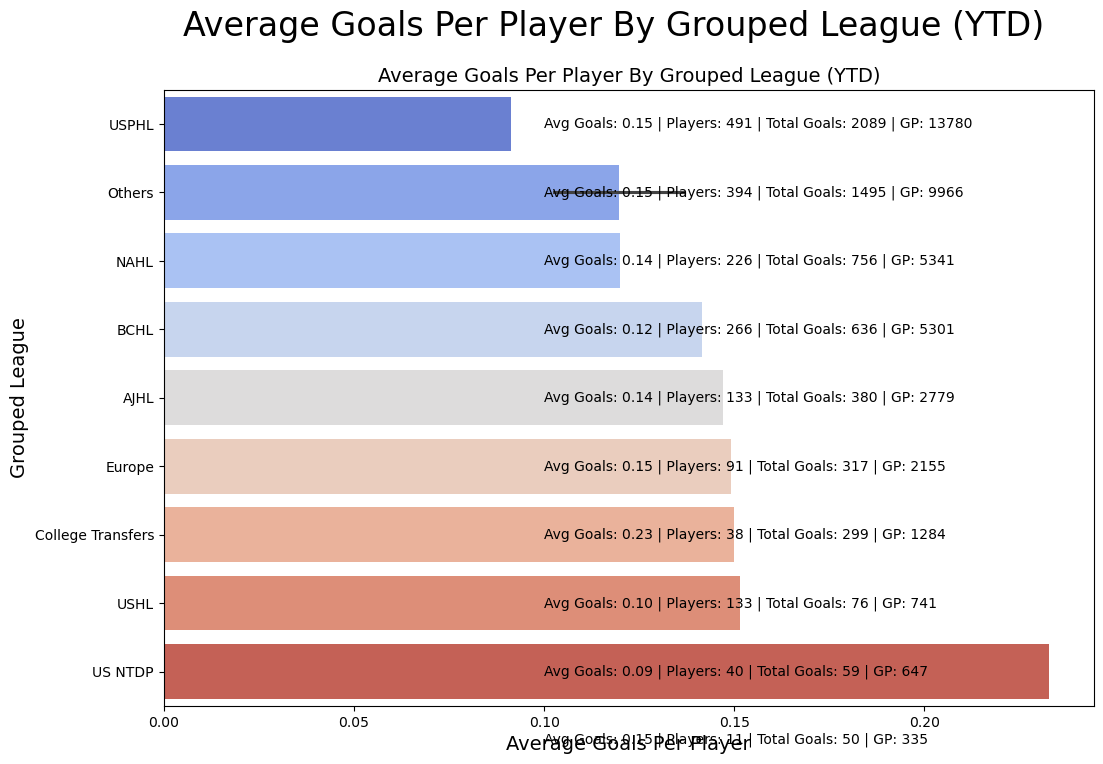

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Generate some dummy data similar to what you might have

# Calulate the averages based on Total_GP

df = grouped_league_stats_df.copy()
df['Avg_Goals_Per_Game'] = df['Total_Goals'] / df['Total_GP']
df['Avg_Assists_Per_Game'] = df['Total_Assists'] / df['Total_GP']
df['Avg_Points_Per_Game'] = df['Total_Points'] / df['Total_GP']
df['Avg_Plus_Minus_Per_Game'] = df['Total_Plus_Minus'] / df['Total_GP']
df['Avg_Shots_Per_Game'] = df['Total_Shots'] / df['Total_GP']
df['Avg_PIM_Per_Game'] = df['Total_PIM'] / df['Total_GP']

# add these new columns back to the grouped league stats dataframe
grouped_league_stats_df = df



# Sort the DataFrame by 'Avg_Goals_Per_Player'
grouped_league_stats_df.sort_values('Avg_Goals_Per_Game', inplace=True)

# Annotation parameters
annotation_fontsize = 10
annotation_x_position = 0.1  # Distance from the y-axis
annotation_color = 'black'

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle('Average Goals Per Player By Grouped League (YTD)', fontsize=24)

# Plot the data
barplot = sns.barplot(x='Avg_Goals_Per_Game', y='Grouped_League', data=grouped_league_stats_df, 
            palette='coolwarm', ax=ax)

# Add labels and title
font_param_dict = {'fontsize': 14}
ax.set_title('Average Goals Per Player By Grouped League (YTD)', font_param_dict)
ax.set_xlabel('Average Goals Per Player', font_param_dict)
ax.set_ylabel('Grouped League', font_param_dict)

# Add annotations for average goals
for index, row in grouped_league_stats_df.iterrows():
    avg_goals = row['Avg_Goals_Per_Game']
    num_games = row['Total_GP']
    ## Count the number of players in each league
    num_players = len(master_roster_df[master_roster_df['Grouped_League'] == row['Grouped_League']])
    total_goals = row['Total_Goals']
    
    plt.text(annotation_x_position, index,
             f"Avg Goals: {avg_goals:.2f} | Players: {num_players} | Total Goals: {total_goals} | GP: {num_games}",
             va='center', fontsize=annotation_fontsize, color=annotation_color)

# Highlight bars that exceed a threshold
threshold = 3.0
for p in barplot.patches:
    if p.get_width() > threshold:
        p.set_color('red')

# Show the plot
plt.show()


## Create the Same Chart for Points instead of Goals

C:\Users\Justin\AppData\Local\Temp\ipykernel_15412\2260179886.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Avg_Points_Per_Game', y='Grouped_League', data=grouped_league_stats_df,


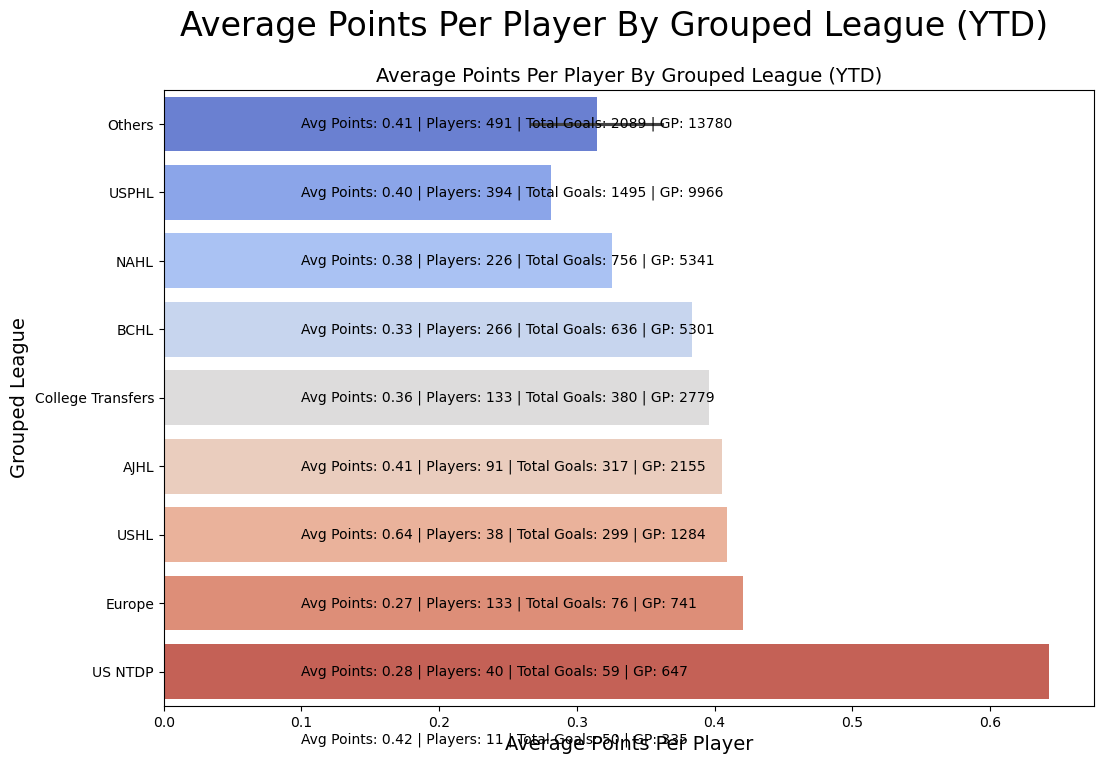

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Generate some dummy data similar to what you might have

# # Calulate the averages based on Total_GP

# df = grouped_league_stats_df.copy()
# df['Avg_Goals_Per_Game'] = df['Total_Goals'] / df['Total_GP']
# df['Avg_Assists_Per_Game'] = df['Total_Assists'] / df['Total_GP']
# df['Avg_Points_Per_Game'] = df['Total_Points'] / df['Total_GP']
# df['Avg_Plus_Minus_Per_Game'] = df['Total_Plus_Minus'] / df['Total_GP']
# df['Avg_Shots_Per_Game'] = df['Total_Shots'] / df['Total_GP']
# df['Avg_PIM_Per_Game'] = df['Total_PIM'] / df['Total_GP']

# # add these new columns back to the grouped league stats dataframe
# grouped_league_stats_df = df



# Sort the DataFrame by 'Avg_Goals_Per_Player'
grouped_league_stats_df.sort_values('Avg_Points_Per_Game', inplace=True)

# Annotation parameters
annotation_fontsize = 10
annotation_x_position = 0.1  # Distance from the y-axis
annotation_color = 'black'

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 8))
fig.suptitle('Average Points Per Player By Grouped League (YTD)', fontsize=24)

# Plot the data
barplot = sns.barplot(x='Avg_Points_Per_Game', y='Grouped_League', data=grouped_league_stats_df, 
            palette='coolwarm', ax=ax)

# Add labels and title
font_param_dict = {'fontsize': 14}
ax.set_title('Average Points Per Player By Grouped League (YTD)', font_param_dict)
ax.set_xlabel('Average Points Per Player', font_param_dict)
ax.set_ylabel('Grouped League', font_param_dict)

# Add annotations for average goals
for index, row in grouped_league_stats_df.iterrows():
    avg_points = row['Avg_Points_Per_Game']
    num_games = row['Total_GP']
    ## Count the number of players in each league
    num_players = len(master_roster_df[master_roster_df['Grouped_League'] == row['Grouped_League']])
    total_goals = row['Total_Goals']
    
    plt.text(annotation_x_position, index,
             f"Avg Points: {avg_points:.2f} | Players: {num_players} | Total Goals: {total_goals} | GP: {num_games}",
             va='center', fontsize=annotation_fontsize, color=annotation_color)

# Highlight bars that exceed a threshold
threshold = 3.0
for p in barplot.patches:
    if p.get_width() > threshold:
        p.set_color('red')

# Show the plot
plt.show()
